# Project: Investigation of No-Show Appointments in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
This project looks at a dataset of 100k+ medical appointments from the city of Vitoria, Brazil to try and understand why 20% of appointments are missed.  The original data set can be found here: https://www.kaggle.com/joniarroba/noshowappointments

This dataset can be analyzed from a variety of angles but this notebook specifically looks at the appointment details and the scholarships, answering the below questions.

### Appointment Details - How do the appointment details influence arrivals?
To answer the main question, we will look into the below three sub-questions.
* Does the appointment day of the week influence arrival?
* Are the SMS reminders effective? And what if compared to the appointment day?
* Does an increase in waiting time affect the arrival?

### Scholarships - How do scholarships influence arrivals?
To answer the main question, we will investigate the below two sub-questions.
* Do the people receiving the stipend arrive to appointments more often than non-recipients?
* Are the neighbourhoods with a high percentage of no-shows inhabited by fewer scholarship recipients?

In [1]:
#We firstly import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime #We will need this for later on
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The overall goal of the data wrangling step is to make the data as clean as possible for the exploration stage. We start by loading the data and then do the initial cleaning of addressing null values, duplicates, and incorrect data types.

In [2]:
#Data is loaded and the head viewed.
df = pd.read_csv('appointments.csv')
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [3]:
#Investigating data for data types, null values, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
#double checking by column name for null values
def total_missing(df,column_name):
    is_null = df[column_name].isnull().sum()
    return int(is_null)

In [5]:
#Cheking the Handcap and Sholarship columns
total_missing(df, 'Handcap'), total_missing(df, 'Scholarship')

(0, 0)

In [6]:
#Checking for duplicates.
df.duplicated().sum()

0

It is apparent from the above cells that the following cleaning needs to take place:
1. Column names need to be formatted for uniformity and spelling.
2. The data types for PatientID, ScheduledDay, and AppointmentDay need to be updated to string, datetime and datetime.
3. The neighbourhoods need to be formatted with capitalization.

We also see from above that all rows have complete data, therefore, it is unnecessary to drop null values. Likewise, there aren't any duplicate rows so no need to delete duplicates.

We will most likely find additional necessary changes as we proceed with cleaning.

### Data Cleaning

COLUMN NAMES

The column names need to be renamed to ensure formatting uniformity and correct spelling.  All column names are to be changed to lowercase, an underscore is inserted between words, hyphens are removed, and spelling corrected.


In [7]:
#Lowercase column names.
df.columns = map(str.lower, df.columns)

#Additional formatting can easily be done by using a dictionary of new names.  Switched the day columns to date 
#so that an appointment day can be calculated later.
df.rename(columns = {'patientid':'patient_id', 'appointmentid':'appt_id','scheduledday':'scheduled_date',
                    'appointmentday': 'appt_date', 'hipertension':'hypertension', 'handcap':'handicap', 
                    'no-show':'no_show'},inplace = True)

In [8]:
#Ensure changes were made.
df.head(1)

,patient_id,appt_id,gender,scheduled_date,appt_date,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


DATA TYPES

The following data types need to be changed.
* Patient ID changed from a float to an integer.  Even though calculations won't be made on this number, it is
kept as a number rather than string as it appears the hospitals give out IDs by incrementing a number. 
* Scheduled Day and Appointment Day changed to a datetime. As the appointment date does not include a time (all times being 00:00:00),both the scheduled date and appointment date are changed into a datetime type formatted as year-month-date.

In [9]:
#Patient ID to int.
df['patient_id'] = df['patient_id'].astype(int)

In [10]:
#Function to change date columns from strings to datetime.
def time_split(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: x.split("T")[0])\
    .apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
    return df.head(1)

In [11]:
#Changing scheduled date column
time_split(df, 'scheduled_date')

,patient_id,appt_id,gender,scheduled_date,appt_date,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [12]:
#Changing appt date column
time_split(df, 'appt_date')

,patient_id,appt_id,gender,scheduled_date,appt_date,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id        110527 non-null int64
appt_id           110527 non-null int64
gender            110527 non-null object
scheduled_date    110527 non-null datetime64[ns]
appt_date         110527 non-null datetime64[ns]
age               110527 non-null int64
neighbourhood     110527 non-null object
scholarship       110527 non-null int64
hypertension      110527 non-null int64
diabetes          110527 non-null int64
alcoholism        110527 non-null int64
handicap          110527 non-null int64
sms_received      110527 non-null int64
no_show           110527 non-null object
dtypes: datetime64[ns](2), int64(9), object(3)
memory usage: 11.8+ MB


Neighbourhood Names

Lastly we want to format the neighbourhood data to be structured with the first letter of each word capitalized. This isn't a mandatory step but rather more visually appealing than a name in all caps.

In [332]:
#Neighbourhood rows changed to a title format, where the first letter of each word is capitalized.
df.neighbourhood = df.neighbourhood.str.title()

We have completed the initial data wrangling steps.  As expected, now that the data has been worked with and investigated more, additional wrangling needs have appeared. We will now add in a few new columns: arrived, appointment_day, and waiting_time.


NEW COLUMN: Arrived

The No-Show column can be easily misunderstood due to the use of a double negative.  To make this clearer to the user, the column will be replaced with a new column named Arrived, the value of which being the opposite of the No-Show column but as an integer rather than a string, allowing us to do calculations easier later on.  The no-show column will then redundant and, therefore, dropped.

In [333]:
#Arrived column created and populated.
df['arrived'] = ''
df['arrived'] = df['no_show'].apply(lambda x: 1 if x == 'No' else 0)
df.head()

,patient_id,appt_id,gender,scheduled_date,appt_date,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,arrived
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,Jardim Da Penha,0,1,0,0,0,0,No,1
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,Jardim Da Penha,0,0,0,0,0,0,No,1
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,Mata Da Praia,0,0,0,0,0,0,No,1
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,Pontal De Camburi,0,0,0,0,0,0,No,1
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,Jardim Da Penha,0,1,1,0,0,0,No,1


In [334]:
#Checking data. Please note that in the dataframe all the columns would have the same count when using the count()
#method.  Therefore any column can be chosen at random.  In this notebook I use the gender column.
df.query('no_show in "No"').gender.count() == df.query('arrived == 1').gender.count()

True

In [335]:
#Checking data.
df.query('no_show in "Yes"').gender.count()== df.query('arrived == 0').gender.count()

True

In [336]:
#Dropping the no-show column now that it is redundant.
df.drop(columns = ['no_show'], inplace = True)

NEW COLUMNS: Apointment Day No

In the exploration phase we will want to interrogate if the day of week influences arrival.  A new column will be created through a series of steps to find the appointment day based on the appointment date column.

In [337]:
#New column for day of week.  There are multiple ways to create a new column.  This time the insert() method 
#is used.  
df.insert(5, 'appt_day_no', 'None')
df.head(1)

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
0,29872499824296,5642903,F,2016-04-29,2016-04-29,None,62,Jardim Da Penha,0,1,0,0,0,0,1


In [338]:
#Using a lambda statement it is possible to pull the day of the week from the appointment date.
#The isoweekday() method defaults to Monday = 1.
from datetime import date
col = ['appt_date']
for c in col:
    df['appt_day_no'] = df[c].apply(lambda x: x.isoweekday())

In [339]:
#Ensuring changes are correct.
df.head(1)

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
0,29872499824296,5642903,F,2016-04-29,2016-04-29,5,62,Jardim Da Penha,0,1,0,0,0,0,1


NEW COLUMN: Appointment Day

The Day number can be useful for calculations but often it is easier for an user to read the name of the day.  Such a column has been inserted.

In [340]:
#Creating and populating the appointment day column.
df.insert(6, 'appt_day', 'None')
col = ['appt_day_no']
for c in col:
    df['appt_day'] = df[c].apply(lambda x: 'Mon' if x==1 else 
                             'Tues' if x==2 else 
                             'Wed' if x==3 else 
                             'Thur' if x==4 else 
                             'Fri' if x==5 else
                             'Sat' if x==6 else 
                             'Sun' if x==7 else None)
df.head()    

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
0,29872499824296,5642903,F,2016-04-29,2016-04-29,5,Fri,62,Jardim Da Penha,0,1,0,0,0,0,1
1,558997776694438,5642503,M,2016-04-29,2016-04-29,5,Fri,56,Jardim Da Penha,0,0,0,0,0,0,1
2,4262962299951,5642549,F,2016-04-29,2016-04-29,5,Fri,62,Mata Da Praia,0,0,0,0,0,0,1
3,867951213174,5642828,F,2016-04-29,2016-04-29,5,Fri,8,Pontal De Camburi,0,0,0,0,0,0,1
4,8841186448183,5642494,F,2016-04-29,2016-04-29,5,Fri,56,Jardim Da Penha,0,1,1,0,0,0,1


NEW COLUMN: Waiting Time

We later want to explore if patients with longer waiting times tend to miss their apointments.  It is, therefore, necessary to create a column that calculates the waiting time by subtracting the scheduled date from the appointment date. 

In [341]:
#Creating and populating waiting_time column.
df.insert(7, 'waiting_time', df['appt_date']-df['scheduled_date'])
df.head(1)

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
0,29872499824296,5642903,F,2016-04-29,2016-04-29,5,Fri,0 days,62,Jardim Da Penha,0,1,0,0,0,0,1


In [342]:
#Checking data type of waiting time.
df.waiting_time.dtype

dtype('<m8[ns]')

We see in the last cell that the waiting time column data type is a timedelta.  This will be difficult for us to use for calculations going forward.  We will change this datatype rather to an int through a series of steps.

In [343]:
#Firstly change the data type to a string.
df.waiting_time = df.waiting_time.astype(str)
df.waiting_time

0          0 days 00:00:00.000000000
1          0 days 00:00:00.000000000
2          0 days 00:00:00.000000000
3          0 days 00:00:00.000000000
4          0 days 00:00:00.000000000
                     ...            
110522    35 days 00:00:00.000000000
110523    35 days 00:00:00.000000000
110524    41 days 00:00:00.000000000
110525    41 days 00:00:00.000000000
110526    41 days 00:00:00.000000000
Name: waiting_time, Length: 110527, dtype: object

We see that changing the column to a string shows the extent of the information held in the timedelta data type.  All that is relevant for us is the integer.  We can extract this by using the split() method.

In [344]:
#Splitting the string to only return the number.
col = ['waiting_time']
for c in col:
   df[c] = df[c].apply(lambda x: x.split(" ")[0])

df.head(1)

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
0,29872499824296,5642903,F,2016-04-29,2016-04-29,5,Fri,0,62,Jardim Da Penha,0,1,0,0,0,0,1


In [345]:
#Lastly changing this to an integer.
df.waiting_time = df.waiting_time.astype(int)
df.waiting_time

0          0
1          0
2          0
3          0
4          0
          ..
110522    35
110523    35
110524    41
110525    41
110526    41
Name: waiting_time, Length: 110527, dtype: int64

The columns and data types are now in order.  We can move on to looking at the rows and their content.

In [346]:
#Looking at the number of unique values in the columns.
df.nunique()

patient_id         62299
appt_id           110527
gender                 2
scheduled_date       111
appt_date             27
appt_day_no            6
appt_day               6
waiting_time         131
age                  104
neighbourhood         81
scholarship            2
hypertension           2
diabetes               2
alcoholism             2
handicap               5
sms_received           2
arrived                2
dtype: int64

In [347]:
#Function that provides a set of unique values for the requested column
def unique_val(df, column_name):
    unq_set = set()
    for x in df[column_name]:
        unq_set.add(x)
    return unq_set

In [348]:
#Unique values in the handicap
unique_val(df, 'handicap')

{0, 1, 2, 3, 4}

In [349]:
#Unique values in the sms_received and gender column
unique_val(df, 'sms_received'), unique_val(df, 'gender')

({0, 1}, {'F', 'M'})

We can learn a lot from looking at the unique values.  For instance. 

* Patient ID  - This is less than the appointment ID meaning that patients came more than once.
* Appt ID - This is correct as we have the same count of id numbers as we do rows in the data base.
* Ages - There is a large range of ages that we should investigate further to ensure there aren't errors.
* Waiting Time - There is a range of 131 waiting time.  We should review further to check for any errors.
* Neighbourhood - There are 81 neighbourhoods.  We should ensure there aren't any errors, specifically spelling mistakes.
* Handicaps - There are 5 options here.  We should investigate what these handicaps represent.
* Lastly, many of the columns list unique value of 2 and all these columns should have only 2 unique values, so this is accurate.

Before digging deeper into the data, I stopped to see if there was further documentation. 
As this was a Kaggle dataset it also is accompanied by the discussion forum and I learned (and can compare with the dataset) the following.

Ages 
* One of the values in the age category is a -1.  Reviewing the Kaggle discussion board it appears this -1 is to represent a newborn child but the consensus is to delete this row as it is the only entry with a negative value.
* The age of 0 was confirmed through Kaggle discussions that this is for a child not yet 1, so a newborn.
* There are quite a few entries with ages over 100.  This is to be explored to see if this is in error.

Handicaps
* I initially assumed the handicaps were for binary numbers and represented a type of handicap.  Upon further reading it was found that this thinking was inaccurate and that actually it is the number of handicaps, so a patient with a number 2 has 2 handicaps.  The dataset does not differentiate regarding what type of handicap(s) the patient has.

SMS Received
* According to the Kaggel discussion board this is also not a binary but rather an integer for number of SMS messages sent.  Therefore 0 means no messages and 1 means 1 message, etc. This version of the dataset has only 0 and 1 whereas it seems previous datasets included additional numbers.

Next steps is to look into ages, waiting time and neighbourhood.  Starting with age we will drop the individual with the -1 age and investigate the individuals with ages over 100.

In [350]:
#Checking for the individual with a negative age.
df.query('age<0')

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
99832,465943158731293,5775010,F,2016-06-06,2016-06-06,1,Mon,0,-1,Romão,0,0,0,0,0,0,1


In [351]:
#Deleting row with the negative age. 
df.query('age <0')
df.drop(df[df.age<0].index, inplace = True)
df.query('age <0')

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived


In [352]:
#Looking for the patients older than 100.
df.query('age >99')

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
58014,976294799775439,5651757,F,2016-05-03,2016-05-03,2,Tues,0,102,Conquista,0,0,0,0,0,0,1
63912,31963211613981,5700278,F,2016-05-16,2016-05-19,4,Thur,3,115,Andorinhas,0,0,0,0,1,0,0
63915,31963211613981,5700279,F,2016-05-16,2016-05-19,4,Thur,3,115,Andorinhas,0,0,0,0,1,0,0
68127,31963211613981,5562812,F,2016-04-08,2016-05-16,1,Mon,38,115,Andorinhas,0,0,0,0,1,0,0
76284,31963211613981,5744037,F,2016-05-30,2016-05-30,1,Mon,0,115,Andorinhas,0,0,0,0,1,0,1
79270,9739429797896,5747809,M,2016-05-30,2016-05-31,2,Tues,1,100,Tabuazeiro,0,0,0,0,1,0,1
79272,9739429797896,5747808,M,2016-05-30,2016-05-31,2,Tues,1,100,Tabuazeiro,0,0,0,0,1,0,1
90372,234283596548,5751563,F,2016-05-31,2016-06-02,4,Thur,2,102,Maria Ortiz,0,0,0,0,0,0,1
92084,55783129426615,5670914,F,2016-05-06,2016-06-03,5,Fri,28,100,Antônio Honório,0,0,0,0,0,1,1
97666,748234579244724,5717451,F,2016-05-19,2016-06-03,5,Fri,15,115,São José,0,1,0,0,0,1,1


In [353]:
#Grouping by patient ID to see if the patients had more than 1 appointment. 
df.groupby(['age','patient_id']).count().query('age >99')

appt_id  gender  scheduled_date  appt_date  appt_day_no  \
age patient_id                                                                 
100 393964189799           1       1               1          1            1   
    9739429797896          2       2               2          2            2   
    55783129426615         1       1               1          1            1   
102 234283596548           1       1               1          1            1   
    976294799775439        1       1               1          1            1   
115 31963211613981         4       4               4          4            4   
    748234579244724        1       1               1          1            1   

                     appt_day  waiting_time  neighbourhood  scholarship  \
age patient_id                                                            
100 393964189799            1             1              1            1   
    9739429797896           2             2              2            2   
    55783129426615          1             1              1            1   
102 234283596548            1             1              1            1   
    976294799775439         1             1              1            1   
115 31963211613981          4             4              4            4   
    748234579244724         1             1              1            1   

                     hypertension  diabetes  alcoholism  handicap  \
age patient_id                                                      
100 393964189799                1         1           1         1   
    9739429797896               2         2           2         2   
    55783129426615              1         1           1         1   
102 234283596548                1         1           1         1   
    976294799775439             1         1           1         1   
115 31963211613981              4         4           4         4   
    748234579244724             1         1           1         1   

                     sms_received  arrived  
age patient_id                              
100 393964189799                1        1  
    9739429797896               2        2  
    55783129426615              1        1  
102 234283596548                1        1  
    976294799775439             1        1  
115 31963211613981              4        4  
    748234579244724             1        1

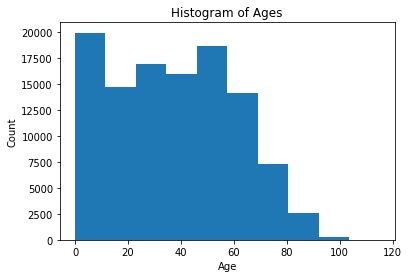

In [354]:
#Looking at histogram to see if these individuals are outliers
df['age'].hist(grid = False);
plt.title("Histogram of Ages")
plt.xlabel("Age")
plt.ylabel("Count");

There are 11 individuals over the age of 100.  These could be considered outliers but also could be just the tail end of the distribution.  I decided to keep in the dataset.

We can now move to investigating the waiting times.

In [355]:
#Sorting waiting times from smallest to largest.
df = df.sort_values(by = 'waiting_time')
df.head(10)

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
71533,998231581612122,5686628,F,2016-05-11,2016-05-05,4,Thur,-6,81,Santo Antônio,0,0,0,0,0,0,0
72362,3787481966821,5655637,M,2016-05-04,2016-05-03,2,Tues,-1,7,Tabuazeiro,0,0,0,0,0,0,0
64175,24252258389979,5664962,F,2016-05-05,2016-05-04,3,Wed,-1,22,Consolação,0,0,0,0,0,0,0
55226,7896293967868,5715660,F,2016-05-18,2016-05-17,2,Tues,-1,19,Santo Antônio,0,0,0,0,1,0,0
27033,7839272661752,5679978,M,2016-05-10,2016-05-09,1,Mon,-1,38,Resistência,0,0,0,0,1,0,0
57785,63578717945831,5657787,M,2016-05-04,2016-05-04,3,Wed,0,46,Nova Palestina,0,0,0,0,0,0,0
57786,7758559298974,5711827,F,2016-05-18,2016-05-18,3,Wed,0,48,Nova Palestina,0,0,0,0,0,0,1
57787,8867812918895,5735495,F,2016-05-25,2016-05-25,3,Wed,0,58,Nova Palestina,0,1,0,0,0,0,1
57788,399649431646135,5713274,M,2016-05-18,2016-05-18,3,Wed,0,56,Nova Palestina,0,0,1,0,0,0,1
57789,16371349179368,5735642,F,2016-05-25,2016-05-25,3,Wed,0,47,Nova Palestina,0,0,0,0,0,0,0


There are 5 rows with a negative value which doesn't make sense. As 5 rows in a database of 100k+ is minimal, these rows are deleted.

In [356]:
#Deleting negative waiting times rows.
df.drop(df.index[0:5], inplace=True)
df.head(10)

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
57785,63578717945831,5657787,M,2016-05-04,2016-05-04,3,Wed,0,46,Nova Palestina,0,0,0,0,0,0,0
57786,7758559298974,5711827,F,2016-05-18,2016-05-18,3,Wed,0,48,Nova Palestina,0,0,0,0,0,0,1
57787,8867812918895,5735495,F,2016-05-25,2016-05-25,3,Wed,0,58,Nova Palestina,0,1,0,0,0,0,1
57788,399649431646135,5713274,M,2016-05-18,2016-05-18,3,Wed,0,56,Nova Palestina,0,0,1,0,0,0,1
57789,16371349179368,5735642,F,2016-05-25,2016-05-25,3,Wed,0,47,Nova Palestina,0,0,0,0,0,0,0
57791,548828668484667,5711493,F,2016-05-18,2016-05-18,3,Wed,0,39,Nova Palestina,0,0,0,0,0,0,1
57817,48872248573417,5653874,F,2016-05-03,2016-05-03,2,Tues,0,58,Nova Palestina,0,1,0,0,0,0,1
57822,373839949173,5653882,F,2016-05-03,2016-05-03,2,Tues,0,44,Nova Palestina,1,0,1,0,0,0,0
57832,753356144342564,5707617,M,2016-05-17,2016-05-17,2,Tues,0,78,Nova Palestina,0,1,0,0,0,0,1
57833,4459446354193,5731989,F,2016-05-24,2016-05-24,2,Tues,0,17,Redenção,0,0,0,0,0,0,1


We can now move on to the investigating the neighbourhoods, looking to see if there are any names that seem to be misspelled and should be merged with another neighbourhood.

In [357]:
#Reviewing nieghbourhood names.
df_neighbourhood = df.groupby('neighbourhood').gender.count()
df_neighbourhood.head(40)

neighbourhood
Aeroporto                         8
Andorinhas                     2262
Antônio Honório                 271
Ariovaldo Favalessa             282
Barro Vermelho                  423
Bela Vista                     1907
Bento Ferreira                  858
Boa Vista                       312
Bonfim                         2773
Caratoíra                      2565
Centro                         3334
Comdusa                         310
Conquista                       849
Consolação                     1375
Cruzamento                     1398
Da Penha                       2217
De Lourdes                      305
Do Cabral                       560
Do Moscoso                      413
Do Quadro                       849
Enseada Do Suá                  235
Estrelinha                      538
Fonte Grande                    682
Forte São João                 1889
Fradinhos                       258
Goiabeiras                      700
Grande Vitória                 1071
Gurigica      

In [358]:
df_neighbourhood.tail(41)

neighbourhood
Jesus De Nazareth    2853
Joana D´Arc          1427
Jucutuquara           694
Maria Ortiz          5805
Maruípe              1902
Mata Da Praia         644
Monte Belo            824
Morada De Camburi      96
Mário Cypreste        371
Nazareth              135
Nova Palestina       2264
Parque Industrial       1
Parque Moscoso        802
Piedade               452
Pontal De Camburi      69
Praia Do Canto       1035
Praia Do Suá         1288
Redenção             1553
República             835
Resistência          4430
Romão                2214
Santa Cecília         448
Santa Clara           506
Santa Helena          178
Santa Luíza           428
Santa Lúcia           438
Santa Martha         3131
Santa Tereza         1332
Santo André          2571
Santo Antônio        2744
Santos Dumont        1276
Santos Reis           547
Segurança Do Lar      145
Solon Borges          469
São Benedito         1439
São Cristóvão        1836
São José             1977
São Pedro            244

The neighbourhood data looks clean and accurate.

In [359]:
#Noting shape of df.
df.shape

(110521, 17)

<a id='eda'></a>
## Exploratory Data Analysis

Now that we have a clean dataset we can delve into the analysis, tackling our two mains question.  We will start with the appointment details.

### Appointment Details - How do the appointment details influence arrivals?
Sub-questions
* Does the appointment day of the week influence arrival?
* Are the SMS reminders effective? And what if compared to the appointment day?
* Does an increase in waiting time affect the arrival?

We will split the dataset into two separate dataframes: those that arrived and those that did not.

In [360]:
#Making copies of the main dataframe
df_yes = df.copy()
df_no = df.copy()

In [361]:
#Dataframe of individuals who arrived.
df_yes = df_yes.query('arrived == 1')

#Dataframe of individuals who missed appointments.
df_no = df_no.query('arrived == 0')

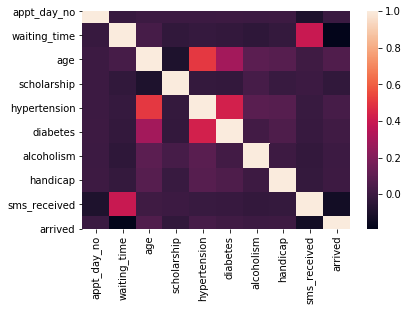

In [362]:
#Before delving into the questions of interest, we can take a quick look at a correlation matrix to see if any
#variables have a strong correlation. 
df_vis = df.drop(columns = ['patient_id','appt_id'])
corr_matrix = df_vis.corr()
sns.heatmap(corr_matrix)
plt.show()

The variables of interest in this analysis are appointment day number, waiting time, sms reminders, scholarship, and neighbourhoods.  The only one of these that show any noticeable correlation are sms received compared to waiting time.  We will re-circle back to this when relevant.

#### 1.1 Does the appointment day of the week influence arrival?

We start by grouping by the day of the week. We will then calculate proportion of no-shows by the day's total appointments.

In [363]:
#Calculating the total appointments per day.
#Once again we could use any of the columns to use a count. This dataset continues to use the gender column.
#As we want the total appointments we do the calculation based off the the original df.
total_per_day = df.groupby(['appt_day_no']).gender.count()
total_per_day

appt_day_no
1    22713
2    25638
3    25866
4    17246
5    19019
6       39
Name: gender, dtype: int64

In [364]:
#Finding the no-shows by day. We now use the df_no dataframe.
no_per_day = df_no.groupby('appt_day_no').count().gender
no_per_day

appt_day_no
1    4689
2    5150
3    5092
4    3337
5    4037
6       9
Name: gender, dtype: int64

In [365]:
#Calculation the proportion of missed appointments by day.
day_prop = (no_per_day/total_per_day).round(2)
day_prop

appt_day_no
1    0.21
2    0.20
3    0.20
4    0.19
5    0.21
6    0.23
Name: gender, dtype: float64

In [366]:
#Finding the mean of the no-shows appointments. Without subtracting from one would give us the mean of individuals 
#who arrived.  We want the mean of those that did not arrive.
round(1 - df['arrived'].mean(),2)

0.2

  We visualise the data using a bar chart to provide a different view.

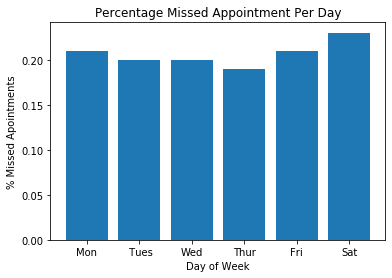

In [367]:
#To make it easier for the user to understand we use the day names as the x tick marks.
days = ['Mon', ' Tues', 'Wed', 'Thur', 'Fri', 'Sat']
plt.bar(days, day_prop )
plt.xlabel ('Day of Week')
plt.ylabel ('% Missed Apointments')
plt.title ('Percentage Missed Appointment Per Day');

1.1 OBSERVATION

There is a slight % difference when looking solely at day, with the biggest difference being on a Saturday. It appears that the weekdays of Tuesday, Wednesday and Thursday see the most arrivals.

#### 1.2 Do the SMS reminders result in an increase of attendance? And what if compared to the appointment day?

First we look at SMS reminders effectiveness in increasing attendance.  We can explore this by looking at the total SMSs sent and the resulting attendance percentages. We will then visualize on a bar chart.

In [368]:
#We want to look at the total number of SMSs sent in order to calculate the proportion. We, therefore, use the
#main df.
total_sms = df.query('sms_received >0').count()

In [369]:
#Calculating the SMS prop by day.
no_sms_prop = ((df_no.query('sms_received >0').count())/total_sms).gender.round(2)
yes_sms_prop = ((df_yes.query('sms_received >0').count())/total_sms).gender.round(2)

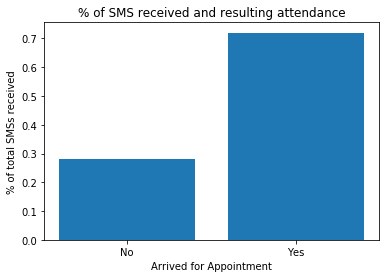

In [370]:
#Visualising.
plt.bar(['No', 'Yes'], [no_sms_prop, yes_sms_prop]);
plt.title('% of SMS received and resulting attendance')
plt.xlabel('Arrived for Appointment')
plt.ylabel('% of total SMSs received');

1.2 Observation 1: Sending SMS reminders significantly increased the likelihood a patient arrived for an appointment.  

1.2.2 The accompanying questions was 'What if we compare SMS received to the appointment day?'

The idea behind this question is to see if the SMSs being sent would translate to less no-shows on the following day.  This does, however, assume that SMSs are sent 1 days in advance.

We can plot the missed appointments per day on the same graphs as the total SMSs by day.

In [371]:
tot_sms_day = df.query('sms_received == 1').groupby(['appt_day_no']).gender.count()

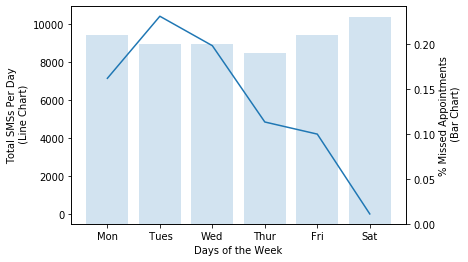

In [372]:
#To make it easier for the user to understand we use the day names as the x tick marks.
days = ['Mon', ' Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(tot_sms_day)
ax2.bar(day_prop.index, day_prop,alpha =0.2)
ax1.set_ylabel("Total SMSs Per Day\n (Line Chart)")
ax1.set_xlabel("Days of the Week")
ax2.set_ylabel('% Missed Appointments\n (Bar Chart)')
ax1.axes.set_xticklabels(days);

Recircling on the heat map we created earlier (and shown again below), there is a slight negative correlation between day of the week and sms received.  But we can also see that there was a strong correlation between waiting time and sms_received, which may mean SMS's are sent out rather only to people who have been waiting for a certain period of time rather than to all patients. 

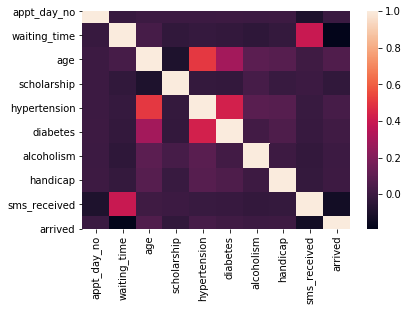

In [373]:
corr_matrix = df_vis.corr()
sns.heatmap(corr_matrix)
plt.show()

1.2.2 OBSERVATION: There doesn't seem to be a correlation between day of the week and if SMS's were sent.

#### 1.3 Do longer waiting times have an influence on arrivals? 

Once again we care about waiting time in comparison to the individuals who did not arrive for an appointment. We run the describe() method to get some general information. 

In [374]:
#Investigating the statistcs of the waiting_time column in the df_no.
df_no['waiting_time'].describe()

count    22314.000000
mean        15.835484
std         16.605600
min          0.000000
25%          4.000000
50%         11.000000
75%         23.000000
max        179.000000
Name: waiting_time, dtype: float64

Looking at the details of the waiting time column we see that there is a range from 0 to 179 in terms of waiting time. But that the mean is 15 days and 75% of the data is 23 days or less. 

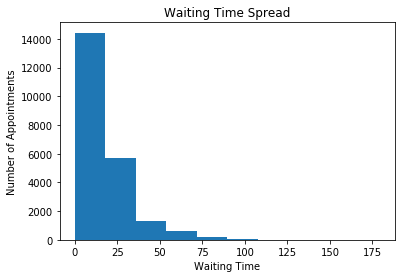

In [375]:
#Looking at the data through a histogram visualisation
df_no['waiting_time'].hist(grid = False)
plt.xlabel("Waiting Time")
plt.ylabel("Number of Appointments")
plt.title('Waiting Time Spread');

The histogram shows that the data is heavily right skewed. We can investigate how many appointments are same-day appointments and at the 90% quartile.

In [376]:
#Looking for how many appointments are same day.
((df_no.query('waiting_time == 0').gender.count())/len(df_no)).round(2)

0.08

In [377]:
#Looking for 90% of data. The 36 number was found through some trial and error of replacing the value.
((df_no.query('waiting_time<36').gender.count())/len(df_no)).round(2)


0.9

Ninety percent of the data has a wait time of 36 days or less.  We, therefore, drop the other data for this analysis.

In [378]:
#Trimming the dataframe of no-shows so that it has 90% of the data and trims the outliers.
df_no_trim = df_no.copy()
df_no_trim = df_no_trim.query('waiting_time<36')
df_no_trim.shape

(20166, 17)

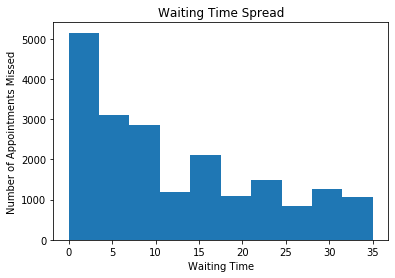

In [379]:
df_no_trim['waiting_time'].hist(bins = 10, grid = False)
plt.xlabel("Waiting Time")
plt.ylabel("Number of Appointments Missed")
plt.title('Waiting Time Spread');

Observation 1.3 - According to the data, the chance of missing appointment _decreases_ the longer the individual has to wait and rather the short-term appointments (especially same day) are missed. 

### Scholarships - How do scholarships influence arrivals?
Sub-questions
* 2.1 Do the people receiving the stipend arrive to appointments more often than non-recipients?
* 2.2 Are the neighbourhoods with a high percentage of no-shows inhabited by fewer scholarship recipients?

#### 2.1 Do the people receiving the stipend arrive to appointments more often than non-recipients?

To investigate this question we will calculate the % of individuals who missed appointments by recipients and non-recepients.

In [380]:
#Making a copy of the dataframe for analysis of scholarships.
df_scholarship = df.copy()
df_scholarship.head()

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
57785,63578717945831,5657787,M,2016-05-04,2016-05-04,3,Wed,0,46,Nova Palestina,0,0,0,0,0,0,0
57786,7758559298974,5711827,F,2016-05-18,2016-05-18,3,Wed,0,48,Nova Palestina,0,0,0,0,0,0,1
57787,8867812918895,5735495,F,2016-05-25,2016-05-25,3,Wed,0,58,Nova Palestina,0,1,0,0,0,0,1
57788,399649431646135,5713274,M,2016-05-18,2016-05-18,3,Wed,0,56,Nova Palestina,0,0,1,0,0,0,1
57789,16371349179368,5735642,F,2016-05-25,2016-05-25,3,Wed,0,47,Nova Palestina,0,0,0,0,0,0,0


In [381]:
#Calculating the % of individuals that receive the scholarship.
sch_yes = df_scholarship.query('scholarship ==1').gender.count()
sch_percentage = (sch_yes / len(df_scholarship)).round(2)
sch_percentage


0.1

The above calculations shows us that 10% of the dataset receive the scholarship.

In [382]:
#Calculating the percentage of scholarship recipients who also missed an appointment.
sch_noshow = df_scholarship.query('scholarship ==1 & arrived == 0').gender.count()
sch_noshow_perc = (sch_noshow / len(df_scholarship)).round(2)
sch_noshow_perc

0.02

In [383]:
#sch_no = df_scholarship.query('scholarship ==0').gender.count()
nosch_noshow = df_scholarship.query('scholarship ==0 & arrived == 0').gender.count()
nosch_noshow_perc = (nosch_noshow / len(df_scholarship)).round(2)
nosch_noshow_perc

0.18

2.1 Observation - We see that of the 20% missed appointments, the majority are from individuals who do not receive the stipend. 

#### 2.2 Are the neighbourhoods with a high percentage of no-shows inhabited by fewer scholarship recipients?

We firstly need to find the neighbourhoods with the highest % of no-shows.  From there we can look at the % of sholarships recipients vs non-recipients in these neighbourhoods.

In [384]:
#Making a copy of the df_no to use for any neighbourhood analysis.
df_nbh = df_no.copy()
df_nbh.head(1)

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
57785,63578717945831,5657787,M,2016-05-04,2016-05-04,3,Wed,0,46,Nova Palestina,0,0,0,0,0,0,0


In [385]:
#Calculating the mean for reference.
noshow_mean = round(1 - df['arrived'].mean(),2)
noshow_mean

0.2

In [386]:
#Looking at that statistics of the no-shows by hospital.
no_count = df_nbh['neighbourhood'].value_counts()
no_count.nlargest(10)

Jardim Camburi       1465
Maria Ortiz          1219
Itararé               923
Resistência           905
Centro                703
Jesus De Nazareth     696
Jardim Da Penha       631
Caratoíra             591
Tabuazeiro            572
Bonfim                550
Name: neighbourhood, dtype: int64

In [387]:
#Total appointments per hospital will be used to find the proportion.
total_appts = df['neighbourhood'].value_counts()
total_appts

Jardim Camburi                 7717
Maria Ortiz                    5805
Resistência                    4430
Jardim Da Penha                3877
Itararé                        3514
                               ... 
Ilha Do Boi                      35
Ilha Do Frade                    10
Aeroporto                         8
Ilhas Oceânicas De Trindade       2
Parque Industrial                 1
Name: neighbourhood, Length: 81, dtype: int64

In [388]:
#Finding the top 5 hopsitals in terms of most missed appointments.
prop_top_five = (no_count / total_appts).nlargest(5).round(2)
prop_top_five

Ilhas Oceânicas De Trindade    1.00
Santos Dumont                  0.29
Santa Cecília                  0.27
Santa Clara                    0.26
Itararé                        0.26
Name: neighbourhood, dtype: float64

Looking at the neighbours we see that one neighbourhood, Ilhas Oceânicas De Trindade, has a 100% no-show rate.  We delve into the details to understand why this is the case.

In [389]:
#Looking at this neighbourhood's apointments.
df_no.query('neighbourhood in "Ilhas Oceânicas De Trindade"')

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
48765,7256429752481,5583948,F,2016-04-14,2016-05-13,5,Fri,29,58,Ilhas Oceânicas De Trindade,0,0,0,0,0,0,0
48754,534986855114,5583947,F,2016-04-14,2016-05-13,5,Fri,29,51,Ilhas Oceânicas De Trindade,0,0,0,0,0,0,0


We see that there were only 2 appointments, both of which were missed.  This is an outlier and needs to be removed.

In [390]:
#Deleting Ilhas Oceânicas De Trindade from the df_no dataframe.
df_nbh.drop(df_nbh[df_nbh.neighbourhood == "Ilhas Oceânicas De Trindade"].index, inplace = True)

In [391]:
#Deleting Ilhas Oceânicas De Trindade from the main dataframe as this is what the total appointments is based on.
#However, we will use the main df but save it to another name to preserve the main df as is.
df_trim = df.drop(df[df.neighbourhood == "Ilhas Oceânicas De Trindade"].index)

In [394]:
#It is necessary to refresh our above calculations and update the total calculation with df_trim.
#Total appointments
total_appts = df_trim.neighbourhood.value_counts()

#Proportion of top 5
prop_top_five = (no_count / total_appts).nlargest(5).round(2)
prop_top_five

Santos Dumont        0.29
Santa Cecília        0.27
Santa Clara          0.26
Itararé              0.26
Jesus De Nazareth    0.24
Name: neighbourhood, dtype: float64

In [395]:
#Looking at the proportion of neighbourhoods above the mean.
prop_above_mean = (no_count / total_appts).nlargest(30).round(2)
prop_above_mean

Santos Dumont          0.29
Santa Cecília          0.27
Santa Clara            0.26
Itararé                0.26
Jesus De Nazareth      0.24
Horto                  0.24
Ilha Do Príncipe       0.23
Caratoíra              0.23
Andorinhas             0.23
Praia Do Suá           0.23
Gurigica               0.23
Bento Ferreira         0.22
Parque Moscoso         0.22
Maruípe                0.22
Do Moscoso             0.22
Enseada Do Suá         0.22
Ariovaldo Favalessa    0.22
Ilha Das Caieiras      0.22
Fonte Grande           0.22
Cruzamento             0.22
São José               0.22
Barro Vermelho         0.22
Nazareth               0.21
Romão                  0.21
Centro                 0.21
Universitário          0.21
São Pedro              0.21
Maria Ortiz            0.21
Santa Helena           0.21
Santos Reis            0.20
Name: neighbourhood, dtype: float64

2.2 OBSERVATION - There are 29 neighbourhoods that have a higher % of missed appointments in comparison to the mean.  

The top five neighbourhoods in terms of missed appointments are Santos Dumont, Santa Cecília, Santa Clara, Itararé, and Jesus De Nazareth.  To continue to answer 2.2 in full, we now look at just these neighbourhoods to understand if the patients who visit these hospitals are scholarship recipients or not.  

In [396]:
#Referencing the neighbourhoods in the top five neighbourhoods
prop_top_five.index.tolist()

['Santos Dumont',
 'Santa Cecília',
 'Santa Clara',
 'Itararé',
 'Jesus De Nazareth']

In [397]:
#Making a copy of the df for scholarship analysis that includes only the five neighbourhoods
df_sch = df.query('neighbourhood in ("Santos Dumont","Santa Cecília","Santa Clara","Itararé", "Jesus De Nazareth")')
df_sch

,patient_id,appt_id,gender,scheduled_date,appt_date,appt_day_no,appt_day,waiting_time,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,arrived
57446,384473663989589,5749224,M,2016-05-31,2016-05-31,2,Tues,0,8,Santa Cecília,0,0,0,0,0,0,1
57494,2719864626435,5705215,M,2016-05-17,2016-05-17,2,Tues,0,11,Jesus De Nazareth,0,0,0,0,0,0,1
58391,53469678337424,5696322,F,2016-05-13,2016-05-13,5,Fri,0,15,Itararé,1,0,0,0,0,0,1
58236,478627674919,5676804,M,2016-05-09,2016-05-09,1,Mon,0,49,Itararé,0,0,0,0,0,0,1
58239,84693826296687,5752856,F,2016-05-31,2016-05-31,2,Tues,0,16,Santos Dumont,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27576,35853623179716,5140323,F,2015-12-08,2016-05-25,3,Wed,169,45,Santa Cecília,0,1,0,0,0,1,1
102819,43517839646243,5163433,F,2015-12-15,2016-06-08,3,Wed,176,58,Santa Cecília,0,1,0,0,0,1,1
102805,939919265925899,5140459,F,2015-12-08,2016-06-01,3,Wed,176,76,Santa Cecília,0,1,0,0,0,0,0
102803,3624378872786,5140456,M,2015-12-08,2016-06-01,3,Wed,176,83,Santa Cecília,0,1,0,0,0,1,0


In [398]:
#Calculating the number of patients from these five neighbourhoods.
total_pat = df_sch.gender.count()

In [399]:
#Calculating number of recipients
yes_sch = df_sch.query('scholarship == 1').gender.count()
yes_sch

871

In [400]:
#Calculating % of recipients
nbh_perc = (yes_sch/total_pat)
nbh_perc

0.1013144120041875

In [401]:
#Percentage of scholarship across the top 5 neighbourhoods
df_sch.groupby('neighbourhood').mean().scholarship


neighbourhood
Itararé              0.088503
Jesus De Nazareth    0.094637
Santa Cecília        0.055804
Santa Clara          0.059289
Santos Dumont        0.184169
Name: scholarship, dtype: float64

2.2 OBSERVATION - The data shows that these neighbourhoods as a whole have a scholarship percentage the same as the mean - 10%.  If we look at the individual neighbourhoods two are less, but the neighbourhood with the highest no-show rates actually has almost double the mean in terms of scholarship recipients.

<a id='conclusions'></a>
## Conclusions
Recircling on our original two questions and the purpose of our analysis:

1) Appointment Details - How do the appointment details influence arrivals?

Arrivals were indeed influenced by certain variables related to appointments, but not all the variables we investigated.  There was an influence based off the day of the week with Saturday showing the most missed appointments and mid-week being the lowest. SMS reminders positively affected individuals showing up to their appointment but a visual trend was inconclusive when comparing to the day of the week. That being said, SMSs could be explored further as in this dataset only 32% of the patients received an SMS. There is a likelihood that these individuals would have shown or no-shown without the SMS reminder. It could be useful to explore further in a dataset where all patients received the SMS reminder.

An increase in waiting time did not result in more missed appointments - in fact, the day with the most no-shows was same-day.  With this dataset we cannot further explore an understanding regarding these same day no-shows but with additinal data one could potentially explore number of walkins to scheduled same-day appointments and if long wait times resulted in people leaving.

2) Scholarships - How do scholarships influence arrivals?

Within this dataset 10% of patients received the scholarship. When looking at missed appointments the 20% of no-shows were made up of only 2% of scholarship recipients, leading one to believe that the scholarship increases the likelihood of arrival.  This could be because the money helps with travel funds and/or also because part of the criteria of the scholarship is to vacinnate children and have them attend school (healthy children will be more likely to attend school).

Drilling down into the neighbourhoods we see the 5 neighbourhoods having the highest percentage of no-shows were:
> * Santos Dumont
> * Santa Cecilia
> * Santa Clara
> * Itarare
> * Jesus De Nazareth

Yet in the neighbourhood specific data the percentage of scholarship recipients was similar to the mean.  Two of the 5 neighbourhoods had a lower percentage but when looking at the 5 neighbourhoods together it was the same as the the total dataset.  It also became apparent that the neighbourhood with the highest no-show rate (Santos Dumont with 29% no-shows) also had patients with 18% as scholarship recipients, far above the mean of 10%. This leads us to believe that the no-shows in these neighbourhoods are not directly tied to lack of scholarship but rather some other variable. 

The analysis in this notebook was insightful. However, in order to pinpoint the key drivers of no-show appointments additional analysis is recommended.